# Learning to use TENSORFLOW HUB - application on DSR Project

In [190]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import seaborn as sb
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from IPython.display import clear_output
import math

## 1A. Downloading the Dataset with groups

In [193]:
from google.colab import files
uploaded = files.upload()

Saving file_name.csv to file_name (3).csv


In [194]:
## Import Emoji description dataset
import io
improved_clusters_df = pd.read_csv(io.BytesIO(uploaded['file_name.csv']))

In [4]:
improved_clusters_df.sample(3, random_state=123)

,Unnamed: 0,Unnamed: 0.1,emoji_symbol,emoji_name,emoji_code,emoji_description,label_name,label_num
189,189,189,🙎,Person Pouting,U+1F64E,"A person with a serious expression,showing mil...",Person-activity,6
1052,1052,1052,💻,Laptop,U+1F4BB,A laptop personal computer. Depicted as a blac...,Objects,5
954,954,954,⚓,Anchor,U+2693,"A metal device, dropped out of a boat to preve...",Travel & Places,10


#### Class distribution

In [5]:
base_color = sb.color_palette()[0]

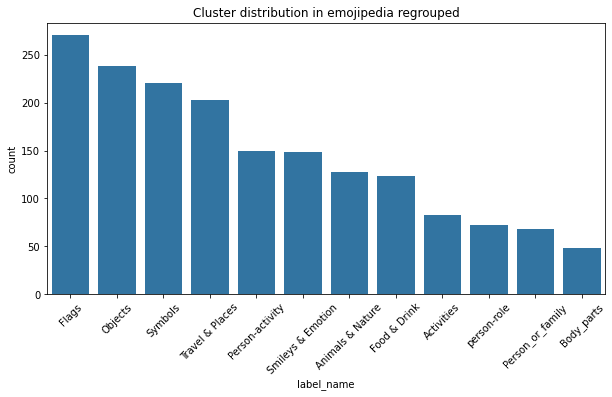

In [6]:
plt.figure(figsize = [10,5])
sb.countplot(data=improved_clusters_df,x='label_name',order=improved_clusters_df.label_name.value_counts().index,
            color=base_color)
plt.xticks(rotation=45)
plt.title('Cluster distribution in emojipedia regrouped');

#### Dictionnary label_num to label_name

In [195]:
# Building a dictionnary label_num to label_name
num_2_name = improved_clusters_df[['label_num', 'label_name']].copy()

In [196]:
num2name = num_2_name.groupby(by='label_name').first()

In [197]:
num2name

,label_num
label_name,
Activities,0
Animals & Nature,1
Body_parts,2
Flags,3
Food & Drink,4
Objects,5
Person-activity,6
Person_or_family,7
Smileys & Emotion,8


In [198]:
num_2_name_lookup = dict(zip(list(num2name.label_num),list(num2name.index)))

In [199]:
df = improved_clusters_df[["emoji_description", "label_num"]].copy()

In [200]:
df.sample(3, random_state=123)

,emoji_description,label_num
189,"A person with a serious expression,showing mil...",6
1052,A laptop personal computer. Depicted as a blac...,5
954,"A metal device, dropped out of a boat to preve...",10


In [201]:
# Taking a copy of the dataframe
dataframe = improved_clusters_df[["emoji_description", "label_num"]].copy()

In [202]:
dataframe.label_num.nunique()

12

## 1B. Data Augmentation

###  Using TextBlob

In [203]:
!pip install -U textblob

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)


In [204]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [205]:
from textblob import TextBlob
from textblob.translate import NotTranslated

In [19]:
def textblob_dataugm(df,name_text_col='features',name_label_col='target'):
  # Extracting a list with all the descriptions and one with the related emojis
  descr_list = list(df[name_text_col])
  label_list = list(df[name_label_col])

  corr_desc = []
  updated_label = [] # In case a NotTransalted Error would be raisen
  for i, descr in enumerate(descr_list):
    print(f'Augmenting description job: {math.ceil(((i+1)/len(label_list))*100)}%')
    clear_output(wait=True)
    blob_descr = TextBlob(descr)
    try:
        fr_descr = blob_descr.correct().translate(from_lang='en', to ='fr')
    except NotTranslated:
        print('Error with ', blob_descr)
    
    try:
        en_descr = fr_descr.translate(from_lang='fr', to='en')
        updated_label.append(label_list[i]) # Only keeping emoji if no NotTranslatedError
        corr_desc.append(str(en_descr).replace("Embolism","emoji").replace("embolism","emoji"))
    except NotTranslated:
        pass
  
  assert len(corr_desc) == len(updated_label)
    
  
  # adding old and new lists together
  new_desc_list = descr_list + corr_desc
  new_label_list = label_list + updated_label

  help_dict = {"features": new_desc_list, "target": new_label_list}
  new_df = pd.DataFrame(help_dict)

  return new_df

## 2. Dataset prepa

#### Creating a train and test dataset from a Pandas DataFrame

source : https://www.tensorflow.org/tutorials/structured_data/feature_columns

 >  Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly.

In [206]:
dataframe.sample(3)

,emoji_description,label_num
260,A femaleastronaut or cosmonaut shown wearing a...,11
227,The Woman Judge emoji is aZWJ sequencecombinin...,11
507,"A skunk, a bushy-tailed mammal that sprays a f...",1


In [207]:
# Updating the names of the columns
dataframe.columns = ['features','target']

In [208]:
dataframe.head(1)

,features,target
0,"A yellow face with simple, open eyes and a bro...",8


#### Dividing in Train and Test Set








In [209]:
# Dividing in train and test set WITHOUT DATA AUGMENTATION
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataframe, test_size=0.2,random_state=123)

print(len(train), 'train examples')
print(len(test), 'test examples')

1401 train examples
351 test examples


#### Divinding in Train and Test Set in case of Data Augmentation

> As the data augmentation, will happen on the train set, here we take a test set that's a bit bigger 

In [23]:
# Dividing in train and test set (Not EXECUTING IF LOADING THE DATA)
#train_augm, test_30pct = train_test_split(dataframe, test_size=0.3,random_state=123) # Taking this time a bigger Test Set

#print(len(train_augm), 'train examples')
#print(len(test_30pct), 'test examples')

1226 train examples
526 test examples


In [ ]:
# DUBBLE THE TRAIN SET BY ADDING TRANSLATION EN-FR-EN
#train_augm = textblob_dataugm(train_augm)   # You can run it in case not possible to load the 

Augmenting description job: 100%


In [ ]:
# Downloading the dataframe locally (Only first time to keep the data locally )
#from google.colab import files
#train_augm.to_csv('train_augm.csv') 
#test_30pct.to_csv('test_30pct.csv')
#files.download('train_augm.csv')
#files.download('test_30pct.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [217]:
upload_train = files.upload()

Saving train_augm.csv to train_augm (4).csv


In [218]:
train_augm = pd.read_csv(io.BytesIO(upload_train['train_augm.csv']))

In [219]:
upload_test = files.upload()

Saving test_30pct.csv to test_30pct (4).csv


In [220]:
test_30pct = pd.read_csv(io.BytesIO(upload_test['test_30pct.csv']))

In [222]:
# Removing first column
train_augm.drop(columns=['Unnamed: 0'],inplace=True)
test_30pct.drop(columns=['Unnamed: 0'],inplace=True)

In [223]:
print(train_augm.shape)

train_augm.sample(10,random_state=123)

(2452, 2)


,features,target
638,The Woman Standing emoji is aZWJ sequencecombi...,6
1195,The Man in Manual Wheelchair emoji is aZWJ seq...,6
556,TheAries astrological sign in the Zodiac. This...,9
1998,"A ball of yarn, used to knit a scarf. Color va...",0
1059,"Apoodle, a popular dog breed with curly hair, ...",1
1205,"CJK Ideographs are characters used in Chinese,...",9
45,"The flag forMarshall Islands, which may show a...",3
993,"A hunk of unspecified meat on a white bone, as...",4
1689,Dark cross button,9
2311,"A magnetic compass, used for navigation. Usual...",10


#### Creating an input pipeline using tf.data 

> Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [29]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batching = True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dataframe.squeeze(), labels.squeeze()))
  print(dataframe.squeeze().shape,labels.shape) # Here important to Squeez() to get t he same Size as expected
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  
  if batching:
    ds = ds.batch(batch_size)
  return ds

#### DATASETS ACTUALLY USED IN THE DIFFERENT MODELS HEREUNDER

In [224]:
# Test without the Batch => THAT WILL BE USED AS INPUT FOR THE DL MODEL (Here WITHOUT DATA AUGMENTATION)
train_ds_nbatch = df_to_dataset(train, batching=False)
test_ds_nbatch = df_to_dataset(test, batching=False)

(1401,) (1401,)
(351,) (351,)


In [225]:
# Test without the Batch => THAT WILL BE USED AS INPUT FOR THE DL MODEL (Here WITH DATA AUGMENTATION)
train_ds_nbatch_dAug = df_to_dataset(train_augm, batching=False)
test_ds_nbatch_dAug = df_to_dataset(test_30pct, batching=False)

(2452,) (2452,)
(526,) (526,)


## 3. Tensorflow Hub

source : https://www.tensorflow.org/tutorials/keras/text_classification_with_hub





In [226]:
import tensorflow_hub as hub

# 20 dimension embedding
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
embedding_layer = hub.KerasLayer(
    embedding,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [227]:
# 128 dimensions embedding
embedding_128D = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embedding_layer_128D = hub.KerasLayer(
    embedding_128D,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [228]:
train_batch, labels_batch = next(iter(train_ds_nbatch.batch(1)))

In [229]:
train_batch

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Ahuman mouth which isgenerally displayed as a pair oflips and a top row of teeth, instead of the inside of themouth.May be used to indicate the spoken wordor as an alternative toKiss Mark.'],
      dtype=object)>

In [230]:
# Example applying the sentence embedding  (20 dimensions)
embedding_layer(train_batch)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 1.2022382 , -0.39622316,  0.03302818,  0.53134656,  0.12631948,
        -0.00242946,  0.1361941 ,  0.4674096 ,  0.8984725 , -1.0131329 ,
        -0.5506793 ,  1.2297844 , -1.3453991 , -0.6293668 , -0.3692836 ,
         0.6206563 ,  0.47048008, -1.1795105 , -1.7920686 , -0.08249285]],
      dtype=float32)>

In [231]:
# Example of applying the the sentence embedding (128 dimensions)
embedding_layer_128D(train_batch)

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 5.01222014e-01, -8.29601735e-02,  7.09252805e-02,
         1.39705643e-01,  2.46646744e-03,  3.86876240e-02,
        -3.59195136e-02,  9.23631713e-02, -1.00288928e-01,
         6.77320659e-02,  7.32084885e-02, -1.20992856e-02,
         6.06046617e-02,  5.77672236e-02, -5.51513694e-02,
         5.19365370e-02, -1.08482480e-01, -1.82524491e-02,
         6.39941022e-02,  4.14254755e-01,  6.05822615e-02,
         1.12661913e-01,  1.30420983e-01, -2.01475583e-02,
         4.38275887e-03, -1.37194186e-01, -1.24933958e-01,
        -4.59575541e-02, -7.21913800e-02, -6.33793175e-02,
         2.68938899e-01,  5.46931960e-02,  1.19517855e-01,
        -7.82397464e-02,  3.92896645e-02,  8.75655264e-02,
        -5.48676215e-02, -1.88796688e-02, -4.13855240e-02,
         1.92473128e-01,  2.29309164e-02,  5.44424094e-02,
        -6.23777919e-02,  5.63733988e-02,  9.77052078e-02,
         2.28913482e-02, -3.27063762e-02,  6.48936704e-02,
      

### Building the Multi-class classification Model

#### Data Variables

In [232]:
# Data WITOUT DATA AUGMENTATION
train_data = train_ds_nbatch
test_data = test_ds_nbatch

In [233]:
# Data WITH DATA AUGMENTATION
train_data_augm = train_ds_nbatch_dAug
test_data_augm = test_ds_nbatch_dAug

In [234]:
# To be used to build the confusion matrix
test_conf, test_labels_conf = next(iter(test_ds_nbatch.batch(351)))

In [235]:
# To be used to build the confusion matrix
test_conf_augm, test_labels_conf_augm = next(iter(test_data_augm.batch(526)))

#### Prepa data 


In [236]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batching = True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dataframe.squeeze(), labels.squeeze()))
  print(dataframe.squeeze().shape,labels.shape) # Here important to Squeez() to get the same Size as expected
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  
  if batching:
    ds = ds.batch(batch_size)
  return ds

In [237]:
def sentence_to_dataset(sentence):
  # Creating a DataFrame
  list_sentences = [sentence]
  df = pd.DataFrame(list_sentences, columns=['sentence'])
  ds = tf.data.Dataset.from_tensor_slices(df)

  return ds


In [238]:
def predict4_one_sentence(sentence, model):
  ds = sentence_to_dataset(sentence)
  pred = model.predict(ds)
  cat_num = np.argmax(pred)
  pred_cluster = num_2_name_lookup[cat_num]
  
  return pred_cluster

In [239]:
def predict4_tfdataset(test_features, test_labels, model):
  # making the predictions on the given dataset
  predictions = model.predict(test_features)
  # converting the feateres and test_labels dataset to a numpy array
  features_2_numpy = tfds.as_numpy(test_features, graph=None)
  labels_2_numpy = tfds.as_numpy(test_labels, graph=None)

  # Looping over the predictions and real labels
  for i,pred in enumerate(predictions):
    # finding back the category
    pred_cluster = num_2_name_lookup[np.argmax(pred)]
    real_cluster = num_2_name_lookup[labels_2_numpy[i]]
    print(f'The sentence is : {features_2_numpy[i]}')
    print(f'The REAL CATEGORY is : {real_cluster} versus the PREDICTED CATEGORY : {pred_cluster}')
    print("")



In [240]:
# confusion matrix
from sklearn.metrics import confusion_matrix

def multiclass_confusion_mat(test_features, test_labels, model):
  # making the predictions on the given dataset
  pred_proba = model.predict(test_features)
  predictions = np.argmax(pred_proba, axis=1) # prediction = arg of max proba

  # converting the test_labels dataset to a numpy array
  labels_2_numpy = tfds.as_numpy(test_labels, graph=None)

  plt.figure(figsize = [10,10])
  cf_matrix = confusion_matrix(labels_2_numpy, predictions)
  sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  plt.xlabel("Predicted Labels")
  plt.ylabel("Real Labels")

In [241]:
def plot_history(history):
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.show()
  plt.close()

  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.legend()
  plt.show()
  plt.close()

In [ ]:
test

#### A. Base Model


In [242]:
# Setting up Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

# Creating an early stopping object early_stopping 
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0.001, 
    mode='auto'
)

**EarlyStopping() has a few options and by default:**
> - _monitor='val_loss':_ 
> 
>> to use validation loss as performance measure to terminate the training.
> - _patience=0:_ 
> 
>> is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.
> 
> - _min_delta:_ 
>
>> Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
> 
>-  _mode='auto':_
> 
>> Should be one of auto, min or max. In 'min' mode, training will stop when the quantity monitored has stopped decreasing; in 'max' mode it will stop when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.

##### I. WITHOUT DATA AUGMENTATION

In [ ]:
base_model = models.Sequential()
base_model.add(embedding_layer)
base_model.add(layers.Dense(100, activation="relu"))
base_model.add(layers.Dense(12, activation="softmax"))
base_model.summary()

base_model.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

In [244]:
base_history = base_model.fit(
    train_data.cache().batch(32),
    epochs=50,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/50
44/44 [==============================] - 1s 12ms/step - loss: 2.1861 - accuracy: 0.2719 - val_loss: 1.7895 - val_accuracy: 0.4416
Epoch 2/50
44/44 [==============================] - 0s 9ms/step - loss: 1.6643 - accuracy: 0.4640 - val_loss: 1.4819 - val_accuracy: 0.5271
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 1.4078 - accuracy: 0.5382 - val_loss: 1.2977 - val_accuracy: 0.5641
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 1.2239 - accuracy: 0.6103 - val_loss: 1.1645 - val_accuracy: 0.6154
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 1.0761 - accuracy: 0.6681 - val_loss: 1.0671 - val_accuracy: 0.6524
Epoch 6/50
44/44 [==============================] - 0s 9ms/step - loss: 0.9526 - accuracy: 0.7159 - val_loss: 0.9925 - val_accuracy: 0.6809
Epoch 7/50
44/44 [==============================] - 0s 10ms/step - loss: 0.8473 - accuracy: 0.7552 - val_loss: 0.9338 - val_accuracy: 0.7009
Epoch 8/50
44/44 [

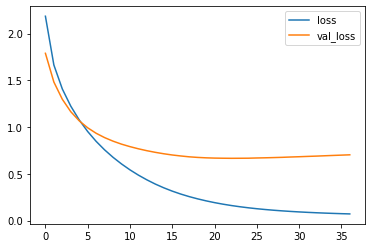

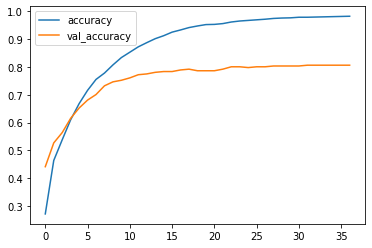

In [245]:
plot_history(base_history)

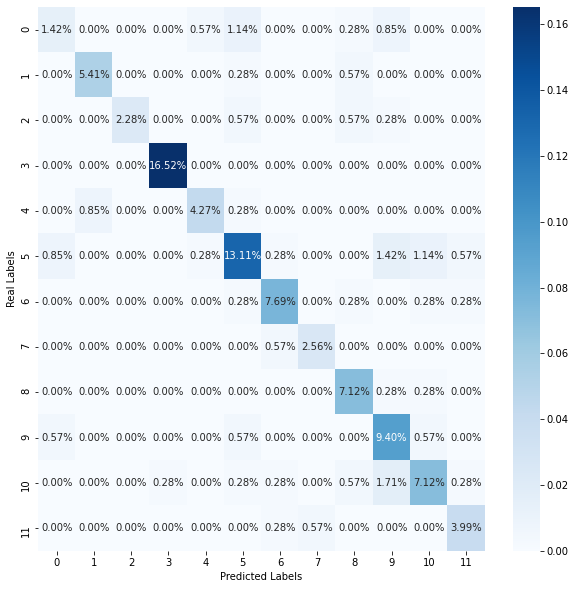

In [68]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model)

In [69]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [91]:
predict4_tfdataset(test_batch, test_labels_batch, base_model)

The sentence is : b'The flag forR\xc3\xa9union, which may show as the lettersREon some platforms.Shown as either theVolcano + Sunbeamsflag proposal by theVexillological Association of R\xc3\xa9union, or theblue, white, red stripes + four colored quadrantsproposal by theAssociation for the R\xc3\xa9union Flag.TheFlag For Franceis the official flag of R\xc3\xa9union. All local flags used are unofficial.The Flag: R\xc3\xa9union emoji is aflag sequencecombining\xf0\x9f\x87\xb7Regional Indicator Symbol Letter Rand\xf0\x9f\x87\xaaRegional Indicator Symbol Letter E.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Flags versus the PREDICTED CATEGORY : Flags

The sentence is : b'A closed, orange, hardcover book\xe2\x80\x94similar to the Emojipedia logo\xf0\x9f\x93\x99\xf0\x9f\x98\x83.Commonly used for various content concerning reading, writing, learning, and schooling. May also be used as an orange accent color.Apple\xe2\x80\x99s cover features the easter eggVo

##### II. WITH DATA AUGMENTATION

In [78]:
base_model_augm = models.Sequential()
base_model_augm.add(embedding_layer)
base_model_augm.add(layers.Dense(100, activation="relu"))
base_model_augm.add(layers.Dense(12, activation="softmax"))
base_model_augm.summary()

base_model_augm.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 403,332
Trainable params: 403,332
Non-trainable params: 0
_________________________________________________________________


In [79]:
base_history_augm = base_model_augm.fit(
    train_data_augm.cache().batch(32),
    epochs=50,
    validation_data=test_data_augm.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/50
77/77 [==============================] - 1s 11ms/step - loss: 1.6500 - accuracy: 0.4918 - val_loss: 1.1584 - val_accuracy: 0.6882
Epoch 2/50
77/77 [==============================] - 1s 8ms/step - loss: 0.8316 - accuracy: 0.8087 - val_loss: 0.7554 - val_accuracy: 0.7947
Epoch 3/50
77/77 [==============================] - 1s 9ms/step - loss: 0.4955 - accuracy: 0.9001 - val_loss: 0.5930 - val_accuracy: 0.8403
Epoch 4/50
77/77 [==============================] - 1s 9ms/step - loss: 0.3427 - accuracy: 0.9299 - val_loss: 0.5204 - val_accuracy: 0.8498
Epoch 5/50
77/77 [==============================] - 1s 9ms/step - loss: 0.2608 - accuracy: 0.9494 - val_loss: 0.4832 - val_accuracy: 0.8593
Epoch 6/50
77/77 [==============================] - 1s 8ms/step - loss: 0.2099 - accuracy: 0.9572 - val_loss: 0.4623 - val_accuracy: 0.8612
Epoch 7/50
77/77 [==============================] - 1s 8ms/step - loss: 0.1753 - accuracy: 0.9608 - val_loss: 0.4504 - val_accuracy: 0.8612
Epoch 8/50
77/77 [=

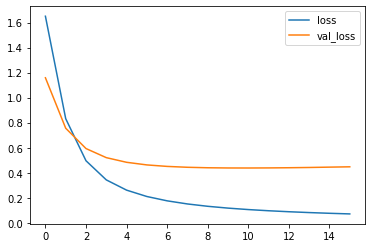

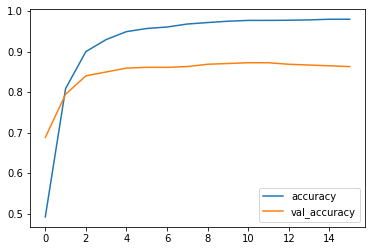

In [80]:
plot_history(base_history_augm)

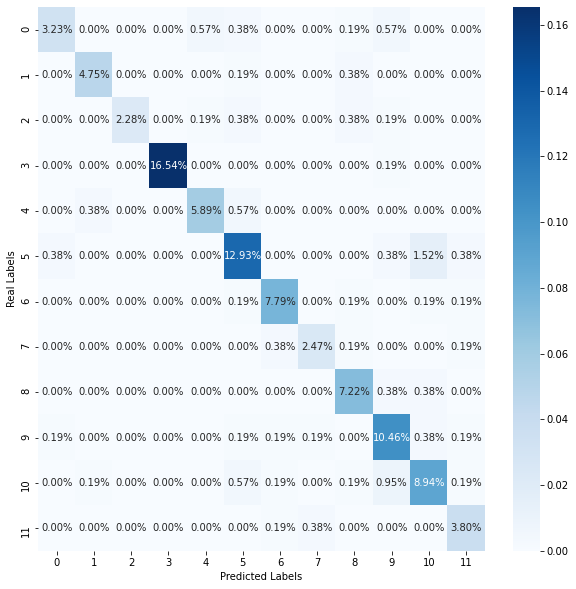

In [81]:
multiclass_confusion_mat(test_conf_augm, test_labels_conf_augm, base_model_augm)

In [93]:
# TAKING A BATCH of the TEST DATA
test_batch_augm, test_labels_batch_augm = next(iter(test_ds_nbatch_dAug.shuffle(300).batch(10)))

In [94]:
predict4_tfdataset(test_batch_augm, test_labels_batch_augm, base_model_augm)

The sentence is : b'Male royalty, intended as a gender pair for theprincess emoji. Shown as amanwith a crown.Not a reference to the musicianPrince, however theman singer emoji on WhatsAppdoes show a character that bears a heavy resemblance to this artist.'
The REAL CATEGORY is : person-role versus the PREDICTED CATEGORY : Person_or_family

The sentence is : b'The edible fungus of the mushroom, depicted as a toadstool with a white-spotted red cap and stem.'
The REAL CATEGORY is : Food & Drink versus the PREDICTED CATEGORY : Food & Drink

The sentence is : b'Ding! A call bell, as pressed at a frontdesk or receptionto alert staff for service, such as from aconciergeor bellhop (porter) to carryluggageat ahotel. Generally depicted as a goldenbellon a wooden stand.Commonly represents alerts or notifications to bring attention to important content. May also be used of various content concerning the hospitality and service industries.Microsoft\xe2\x80\x99s design features a silver bell radiati

#### B. BASE_MODEL but with EMBEDDINLAYER Dimension 128D

##### I. Without Regularization

In [95]:
base_model_128D = models.Sequential()
base_model_128D.add(embedding_layer_128D)
base_model_128D.add(layers.Dense(100, activation="relu"))
base_model_128D.add(layers.Dense(12, activation="softmax"))
base_model_128D.summary()

base_model_128D.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

base_history_128D = base_model_128D.fit(
    train_data.cache().batch(32),
    epochs=15,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
44/44 [==============================] - 62s 1s/step - loss: 2.1061 - accuracy: 0.4026 - val_loss: 1.6830 - val_accuracy: 0.5356
Epoch 2/15
44/44 [==============================] - 61s 1s/step - loss: 1.3436 - accuracy: 0.6817 - val_loss: 1.1631 - val_accuracy: 0.6781
Epoch 3/15
44/44 [==============================] - 61s 1s/step - loss: 0.7338 - accuracy:

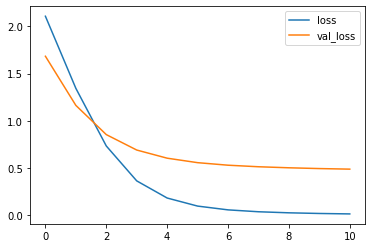

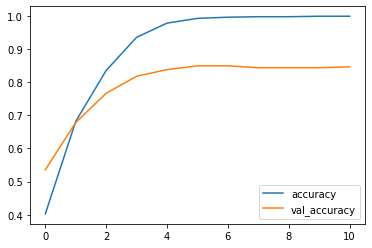

In [96]:
plot_history(base_history_128D)

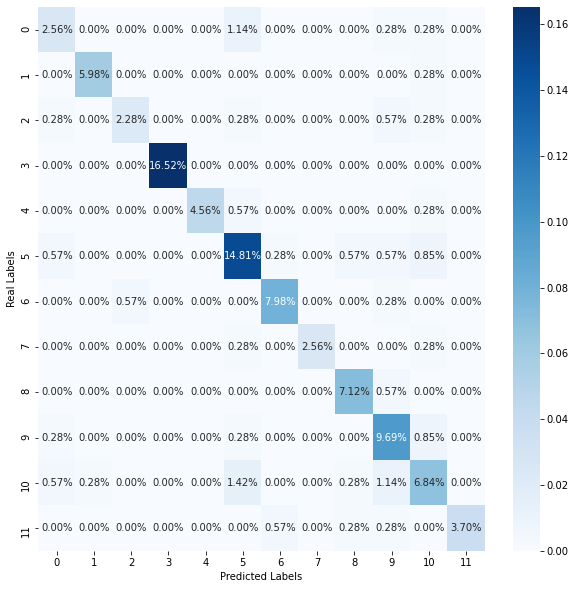

In [97]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D)

In [104]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [105]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D)

The sentence is : b'The male version of the\xf0\x9f\x99\x86Face With OK Gestureemoji.The Man Gesturing OK emoji is aZWJ sequencecombining\xf0\x9f\x99\x86Person Gesturing OK,\xe2\x80\x8dZero Width Joinerand\xe2\x99\x82Male Sign.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Person-activity

The sentence is : b'A globe, showing the continents of Europe and Africa in green against blue ocean.May be used to represent various content concerning the European, African, and Atlantic regions. May also be used to represent Earth and internationalaffairs more generally.See also\xf0\x9f\x8c\x8e Globe Showing Americasand\xf0\x9f\x8c\x8f Globe Showing Asia-Australia.'
The REAL CATEGORY is : Travel & Places versus the PREDICTED CATEGORY : Travel & Places

The sentence is : b'Prescription glasses, shown with a variety of frames, depending on platform.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Trave

II. With Regularization

In [106]:
# hyperparameters:
factor = 0.001
rate =  0.3

##### 1. Only L2 Regularization

In [107]:
base_model_128D_l2 = models.Sequential()
base_model_128D_l2.add(embedding_layer_128D)
base_model_128D_l2.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_l2.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_l2.summary()

base_model_128D_l2.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

base_history_128D_l2 = base_model_128D_l2.fit(
    train_data.cache().batch(32),
    epochs=12,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)


44/44 [==============================] - 61s 1s/step - loss: 0.1815 - accuracy: 0.9993 - val_loss: 0.6841 - val_accuracy: 0.8433
Epoch 9/12
44/44 [==============================] - 61s 1s/step - loss: 0.1716 - accuracy: 0.9993 - val_loss: 0.6734 - val_accuracy: 0.8462


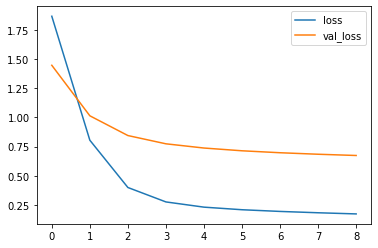

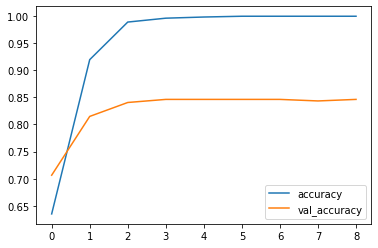

In [108]:
plot_history(base_history_128D_l2)

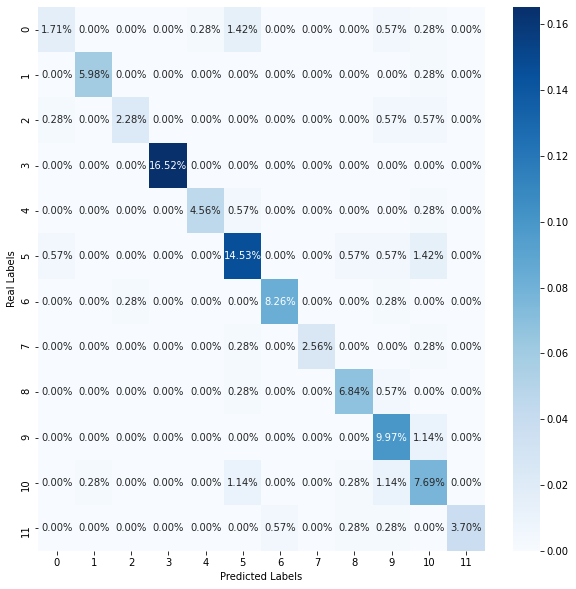

In [109]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D_l2)

In [110]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [111]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_l2)

The sentence is : b'Two hands clapping emoji, which when used multiple times can be usedas a round of applause.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'Thewordfree, shown enclosedin a square.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'The Keycap Digit Nine emoji is akeycap sequencecombining9Digit Nineand\xe2\x83\xa3Combining Enclosing Keycap.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'Creatures with pointed ears and human-like faces.Femaleandmaleelves are available.Elfwas approved as part ofUnicode 10.0in 2017\nand added toEmoji 5.0in 2017.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Person-activity

The sentence is : b'A classic telephone, as a landline home phone. Most platforms depict a red, push-button phone with thehandseton the base.Used fo

#### 2. L2 and Dropout with EarlyStopping

In [112]:
base_model_128D_reg = models.Sequential()
base_model_128D_reg.add(embedding_layer_128D)
base_model_128D_reg.add(layers.Dropout(rate))
base_model_128D_reg.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg.add(layers.Dropout(rate))
base_model_128D_reg.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg.summary()

base_model_128D_reg.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Applying Early Stopping
base_history_128D_reg = base_model_128D_reg.fit(
    train_data.cache().batch(32),
    epochs=30,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/30
44/44 [==============================] - 62s 1s/step - loss: 1.9295 - accuracy: 0.5353 - val_loss: 1.4604 - val_accuracy: 0.7208
Epoch 2/30
44/44 [==============================] - 61s 1s/step - loss: 0.8827 - accuracy: 0.8944 - val_loss: 0.9842 - val_accuracy: 0.8148
Epoch 3/30
44/44 [==============================] - 61s 1s/step - loss: 0.4527 - accuracy: 0.9736 - val_loss: 0.8216 - val_accuracy: 0.8348
Epoch 4/30
44/44 [==============================] - 64s 1s/step - loss: 0.3128 - accuracy: 0.9893 - val_loss: 0.7498 - val_accuracy: 0.8433
Epoch 5/30
44/44 [==============================] - 63s 1s/step - loss: 0.2641 - accuracy: 0.9921 - val_loss: 0.7173 - val_accuracy: 0.8376
Epoch 6/30
44/44 [==============================] - 61s 1s/step - loss: 0.2419 - accuracy: 0.9936 - val_loss: 0.6914 - val_accuracy: 0.8433
Epoch 7/30
44/44 [==============================] - 61s 1s/step - loss: 0.2189 - accuracy: 0.9971 - val_loss: 0.6831 - val_accuracy: 0.8462
Epoch 8/30
44/44 [==

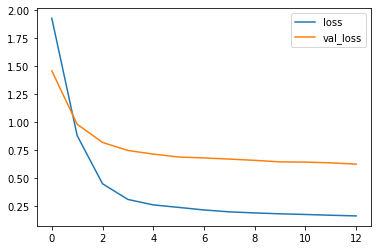

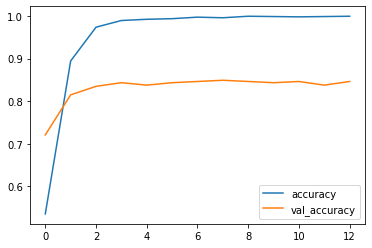

In [161]:
plot_history(base_history_128D_reg)

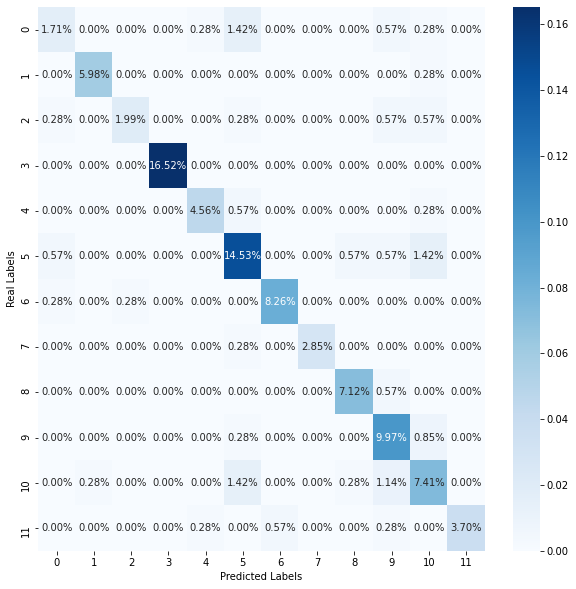

In [162]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D_reg)

In [163]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg)

The sentence is : b'Two hands clapping emoji, which when used multiple times can be usedas a round of applause.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'Thewordfree, shown enclosedin a square.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'The Keycap Digit Nine emoji is akeycap sequencecombining9Digit Nineand\xe2\x83\xa3Combining Enclosing Keycap.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'Creatures with pointed ears and human-like faces.Femaleandmaleelves are available.Elfwas approved as part ofUnicode 10.0in 2017\nand added toEmoji 5.0in 2017.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Person-activity

The sentence is : b'A classic telephone, as a landline home phone. Most platforms depict a red, push-button phone with thehandseton the base.Used fo

##### I. WITH DATA AUGMENTATION

In [164]:
base_model_128D_reg_augm = models.Sequential()
base_model_128D_reg_augm.add(embedding_layer_128D)
base_model_128D_reg_augm.add(layers.Dropout(rate))
base_model_128D_reg_augm.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg_augm.add(layers.Dropout(rate))
base_model_128D_reg_augm.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg_augm.summary()

base_model_128D_reg_augm.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________


In [165]:
# Applying Early Stopping
base_history_128D_reg_augm = base_model_128D_reg_augm.fit(
    train_data_augm.cache().batch(32),
    epochs=30,
    validation_data=test_data_augm.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/30
77/77 [==============================] - 105s 1s/step - loss: 1.5616 - accuracy: 0.6570 - val_loss: 0.8381 - val_accuracy: 0.8384
Epoch 2/30
77/77 [==============================] - 105s 1s/step - loss: 0.5557 - accuracy: 0.9331 - val_loss: 0.5768 - val_accuracy: 0.8859
Epoch 3/30
77/77 [==============================] - 105s 1s/step - loss: 0.3565 - accuracy: 0.9674 - val_loss: 0.5228 - val_accuracy: 0.8897
Epoch 4/30
77/77 [==============================] - 105s 1s/step - loss: 0.2890 - accuracy: 0.9784 - val_loss: 0.5022 - val_accuracy: 0.8916
Epoch 5/30
77/77 [==============================] - 105s 1s/step - loss: 0.2588 - accuracy: 0.9841 - val_loss: 0.4897 - val_accuracy: 0.8897
Epoch 6/30
77/77 [==============================] - 106s 1s/step - loss: 0.2353 - accuracy: 0.9874 - val_loss: 0.4778 - val_accuracy: 0.8897
Epoch 7/30
77/77 [==============================] - 105s 1s/step - loss: 0.2137 - accuracy: 0.9894 - val_loss: 0.4710 - val_accuracy: 0.8935
Epoch 8/30
77

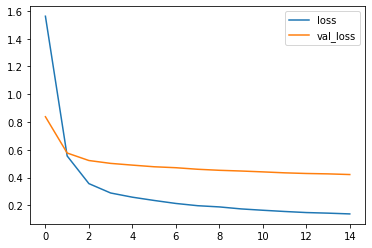

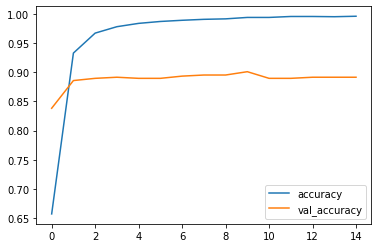

In [166]:
plot_history(base_history_128D_reg_augm)

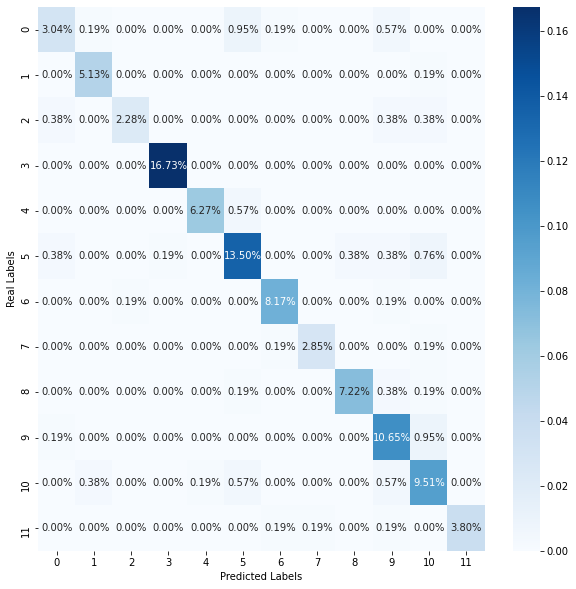

In [167]:
multiclass_confusion_mat(test_conf_augm, test_labels_conf_augm, base_model_128D_reg_augm)

In [168]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg)

The sentence is : b'Two hands clapping emoji, which when used multiple times can be usedas a round of applause.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'Thewordfree, shown enclosedin a square.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'The Keycap Digit Nine emoji is akeycap sequencecombining9Digit Nineand\xe2\x83\xa3Combining Enclosing Keycap.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'Creatures with pointed ears and human-like faces.Femaleandmaleelves are available.Elfwas approved as part ofUnicode 10.0in 2017\nand added toEmoji 5.0in 2017.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Person-activity

The sentence is : b'A classic telephone, as a landline home phone. Most platforms depict a red, push-button phone with thehandseton the base.Used fo

#### II. Trying with less units in the Dense Layer as still overfitting

In [169]:
base_model_128D_reg_less = models.Sequential()
base_model_128D_reg_less.add(embedding_layer_128D)
base_model_128D_reg_less.add(layers.Dropout(rate))
# REDUCING THE AMOUNT OF UNITS IN HIDDEN LAYER
base_model_128D_reg_less.add(layers.Dense(40,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg_less.add(layers.Dropout(rate))
base_model_128D_reg_less.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg_less.summary()

base_model_128D_reg_less.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

# Applying Early Stopping
base_history_128D_reg_less = base_model_128D_reg_less.fit(
    train_data.cache().batch(32),
    epochs=30,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                5160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 12)                492       
Total params: 124,648,340
Trainable params: 124,648,340
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
44/44 [==============================] - 59s 1s/step - loss: 1.9992 - accuracy: 0.3826 - val_lo

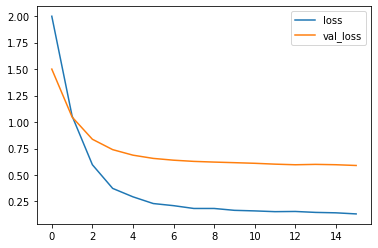

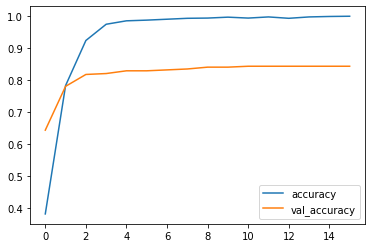

In [172]:
plot_history(base_history_128D_reg_less)

In [187]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg_less)

The sentence is : b'Two hands clapping emoji, which when used multiple times can be usedas a round of applause.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Activities

The sentence is : b'Thewordfree, shown enclosedin a square.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'The Keycap Digit Nine emoji is akeycap sequencecombining9Digit Nineand\xe2\x83\xa3Combining Enclosing Keycap.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Symbols versus the PREDICTED CATEGORY : Symbols

The sentence is : b'Creatures with pointed ears and human-like faces.Femaleandmaleelves are available.Elfwas approved as part ofUnicode 10.0in 2017\nand added toEmoji 5.0in 2017.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Person-activity

The sentence is : b'A classic telephone, as a landline home phone. Most platforms depict a red, push-button phone with thehandseton the base.Used fo